# Initialisation

In [1]:
import pandas as pd
import time
import numpy as np
import NLP_Utils as NU
from ReceipeAnalyzer import ReceipeAnalyzer

In [2]:
cal_to_J = 4.184
J_to_cal = 1/cal_to_J

In [23]:
#The file is about 2.1Go, it might take a few minutes to download
#-nc can be used to avoid downloading the file if it is already present
#Note: this line only works on a linux kernel. You can download the file manually
#!wget -nc "https://fr.openfoodfacts.org/data/fr.openfoodfacts.org.products.csv"

# Load data

In [24]:
t = time.time()

food = pd.read_csv("fr.openfoodfacts.org.products.csv", delimiter = "\t")
print("elapsed: ", time.time() - t)
food.shape

C:\Users\mti\Miniconda3\envs\walecities\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


elapsed:  32.1418514251709


(1120758, 178)

# Analysis

In [26]:
food.energy_100g.isna().sum(), (food.energy_100g > 1000*cal_to_J).sum()

(229799, 1172)

In [27]:
nansum = food.isna().sum()

In [28]:
print('number of missing energy information: %d (%d%%)' % (food.energy_100g.isna().sum(), food.energy_100g.isna().sum()/len(food)*100 ) )
print('number of missing energy information: %d (%.3f%%)' % ((food.energy_100g > 1000*cal_to_J).sum(), (food.energy_100g > 1000*cal_to_J).sum()/len(food)*100 ) )
print('number of empty cells: %d' % nansum.sum())
print('number of cells: %d' % np.prod(food.shape))
print('ratio of empty cells: %d%%' % (nansum.sum()/np.prod(food.shape)*100))

number of missing energy information: 229799 (20%)
number of missing energy information: 1172 (0.105%)
number of empty cells: 157884457
number of cells: 199494924
ratio of empty cells: 79%


In [29]:
len(food)

1120758

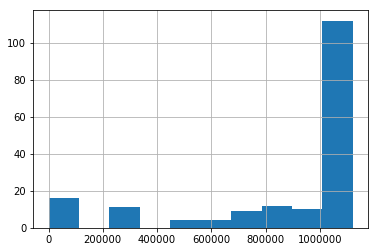

In [24]:
nansum.hist()

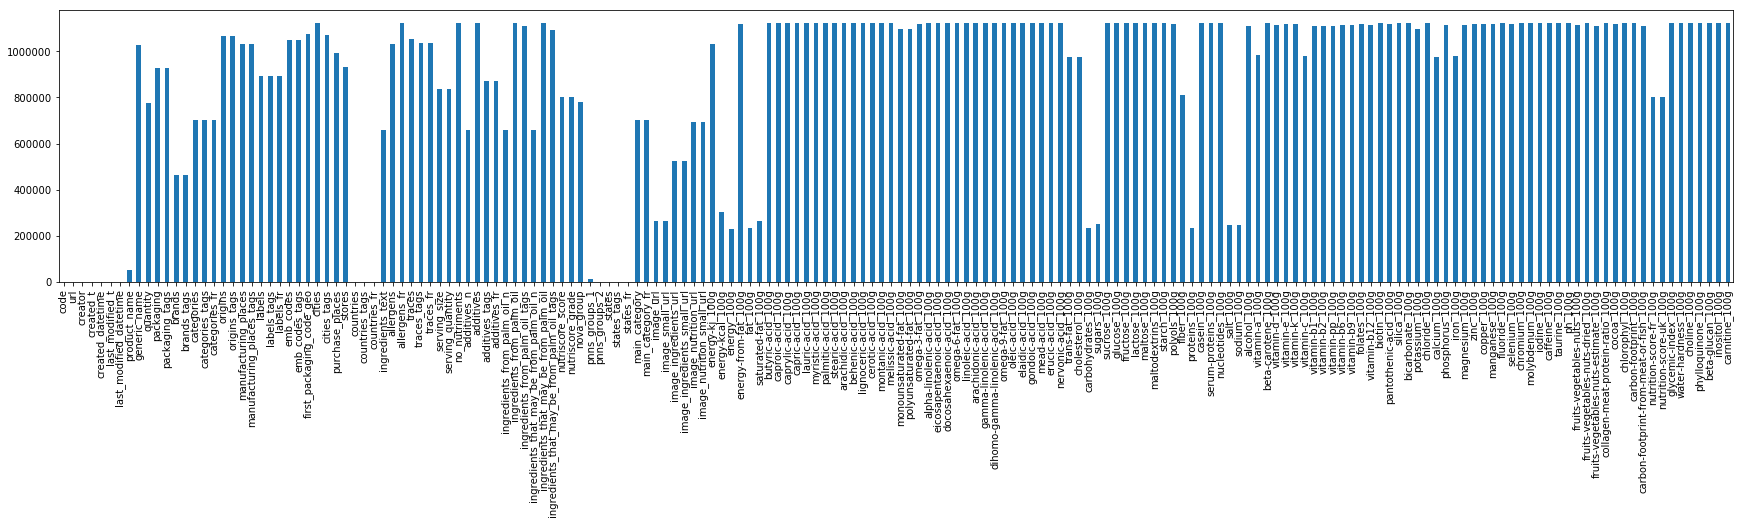

In [28]:
%matplotlib inline
nansum.plot.bar(figsize = (30,5))

In [30]:
#Count empty columns
L = len(food)
(nansum >= 0.9*L).sum()

112

In [54]:
food[food.energy_100g.isna()][['product_name','energy_100g']].head(10)

,product_name,energy_100g
1,Cacao,NaN
2,Filetes de pollo empanado,NaN
4,Sfiudwx,NaN
7,Pistou d'ail des ours,NaN
8,Pain maïs,NaN
9,Mendiants,NaN
10,Sachet calisson,NaN
11,Pate d'amende,NaN
14,NaN,NaN
15,Vainilla,NaN


In [55]:
#Total number of empty cells
totnans = nansum.sum()
totcells = np.prod(food.shape)
totnans, totnans/totcells

(157884457, 0.7914209235719701)

In [56]:
food[food.energy_100g > 1000*cal_to_J][['product_name','energy_100g']].head(10)

,product_name,energy_100g
886,Complete breakfast smoothie,6213.0
1346,Le Fromage de Margot,5393.0
1821,Fruit d'Or 100% végétal,12372.0
2116,Ginger Candy Sweetened With Raw Cane,4435.0
2174,Slim fast KETO meal shake,39748.0
3047,Natural walnut and almond with dried cherries,5977.0
3233,The Original Malted Milk Balls,6276.0
7304,Traditional Dusseldorf Mustard,5690.0
11914,Percy pig,6096.0
12258,"Bellavitano, Merlot Cheese",7020.0


# Pre-processing
* Remove some invalid values (such as energy_100g values)
* Remove non alpha-numeric items
* Convert nutri-score to numeric scale (allowing statistical aggregation)

In [31]:
#find columns related to nutriscore
print([f for f in food.columns if 'nutri' in f])

['no_nutriments', 'nutriscore_score', 'nutriscore_grade', 'image_nutrition_url', 'image_nutrition_small_url', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']


In [32]:
#%% remove entries with nans in energy_100g
food = food[(food.energy_100g.notnull()) & ~food.energy_100g.isna()]
print(len(food))
#%% remove invalid energy data (> 1000 Kcal)
food = food[food.energy_100g < 1000*cal_to_J]
print(len(food))
#%% lowercase product names
food['product_name'] = food['product_name'].str.lower()

#%% remove null/nan and non-ascii/french names
#note: \x00-\x7F stands for ascii characters, to which we add french characters àâéêèìôùûç
food = food[~food['product_name'].str.contains(r'[^àâéêèìôùûç\x00-\x7F]+', na=False)]
food = food[~food['product_name'].isna()]
print(len(food))

#This processing would be too permissive, allowing items such as: 意式番茄味 创意花式薯卷 🍇 raisin sultanine
#food = food[~food['product_name'].str.isalnum()]

#%% convert nutri-score grades (letters A to E) to numbers (1 to 5)
def convertnutriscore(grade):
    return {
        'a': 1,
        'A': 1,
        'b': 2,
        'B': 2,
        'c' : 3,
        'C': 3,
        'd' : 4,
        'D': 4,
        'e' : 5,
        'E': 5
    }.get(grade, grade)

food['nutriscore_grade'] = food.nutriscore_grade.apply(convertnutriscore)

890959
889707
837463


# Keep only products from some countries

In [33]:
searchfor = ['France', 'Belgique', 'Suisse']
#searchfor = ['Belgique']
food = food[food['countries'].str.contains('|'.join(searchfor), na=False)]

In [34]:
len(food)

391017

In [35]:
#force single type for each column

food2 = food.copy()

for c in food2.columns:
    #coltype = food2[c].dtype
    
    #get type of first valid value of the column
    try:
        coltype = type(food2[c].dropna().iloc[0])
    except IndexError as e:
        #column is composed on only invalid values
        coltype = float
    
    food2[c] = food2[c].astype(coltype)
    #food[c] = food[c].astype('O')

In [64]:
food2.to_parquet('openfoodfacts_subset.parquet', compression = 'GZIP')

In [39]:
t = time.time()
food = pd.read_parquet('openfoodfacts_subset.parquet')
print("elapsed: ", time.time() - t)

elapsed:  10.26102590560913


# Process names

In [40]:
stopwords = ['de','du','le','les','aux','la','des', 'a', 'une', 'un', 'au','g','gr','gramme','grammes','kg','kilo','kilos','kilogramme','kilogrammes','d','l']
unit_tests = ["Carottes râpées", "CAROTTE RAPEE 150gr", 'chevaux','150gr de cheval', 'cheval 200 grammes', '100% cheval', 'viande de cheval', "jambon à l'os", "souris d'agneau"]

[NU.preprocess_string(s, stopwords = stopwords) for s in unit_tests]


['carotte rapee',
 'carotte rapee',
 'cheval',
 'cheval',
 'cheval',
 'cheval',
 'viande cheval',
 'jambon os',
 'souris agneau']

In [43]:
#preprocess product names: keep only alphabetic characters
preprocess = lambda x: NU.preprocess_string(x, stopwords = stopwords)
food = food.assign(processed_name = food.product_name.apply(preprocess))

#remove products with empty names
food = food[food.processed_name != '']
#food[['processed_name','product_name']]

# Extraction des produits usuels
* on applique un seuil sur les noms de produits rencontrés plusieurs fois (pour virer les produits très rares)

In [46]:
#différents produits
distinctproducts = food.processed_name.value_counts()

#produits non-usuels
threshunusual = 5
unusualproducts=distinctproducts[distinctproducts < threshunusual]
usualproducts = distinctproducts[distinctproducts >= threshunusual]

#print(unusualproducts)

#%% keep only usual products

usualfood = food[food.processed_name.isin(usualproducts.index)]

len(usualfood)

131509

# Extraction de compositions médianes
* permet de filtrer le bruit
* permet de minimiser les Nan et d'obtenir un maximum d'infos sur un produit

In [47]:
medianfacts = usualfood.groupby('processed_name').median()
allmedianfacts = food.groupby('processed_name').median()

len(medianfacts), len(allmedianfacts)

(8470, 228649)

In [48]:
#add unstemmed product names

medianfacts['product_name'] = medianfacts.index
allmedianfacts['product_name'] = allmedianfacts.index
usualfood['product_name'] = usualfood.processed_name
food['product_name'] = food.processed_name

C:\Users\mti\Miniconda3\envs\walecities\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [87]:
medianfacts.to_parquet('medianfacts.parquet', compression='GZIP')
allmedianfacts.to_parquet('allmedianfacts.parquet', compression='GZIP')


# Chargement des données traitées

In [3]:
medianfacts = pd.read_parquet('medianfacts.parquet')
allmedianfacts = pd.read_parquet('allmedianfacts.parquet')

# Requêtes

In [4]:
analyser = ReceipeAnalyzer()
analyser.valeurs_nutritionnelles('pomme', pretty = True)

Produit,pomme
Nom,pomme
kCal/100g,50.6692
Fibres/100g,1.4
Graisses/100g,0.1
Gaisses saturées/100g,0
Sucre/100g,10.25
Protéines/100g,0.3
Sel/100g,0.01
Sodium/100g,0.004
Additifs,0


In [5]:
valeurs_nutritionnelles = lambda x: display(analyser.valeurs_nutritionnelles(x, pretty = True))
unit_tests = ["chocolat", "Pommes", "tomates"]
for u in unit_tests:
    valeurs_nutritionnelles(u)

Produit,chocolat
Nom,chocolat
kCal/100g,545.889
Fibres/100g,2
Graisses/100g,35
Gaisses saturées/100g,20
Sucre/100g,43
Protéines/100g,6.8
Sel/100g,0.14
Sodium/100g,0.056
Additifs,1


Produit,pomme
Nom,pomme
kCal/100g,50.6692
Fibres/100g,1.4
Graisses/100g,0.1
Gaisses saturées/100g,0
Sucre/100g,10.25
Protéines/100g,0.3
Sel/100g,0.01
Sodium/100g,0.004
Additifs,0


Produit,tomate
Nom,tomate
kCal/100g,21.0325
Fibres/100g,0.8
Graisses/100g,0.2
Gaisses saturées/100g,0
Sucre/100g,3.2
Protéines/100g,0.91
Sel/100g,0.3
Sodium/100g,0.12
Additifs,0


# Extraction de poids unitaires approximés

Pour chaque élément du tableau "medianfacts" (reprenant les information nutritionnelles médianes de produits "usuels"), nous extrayons des estimations
des poids unitaires.

In [3]:

#unit_tests on food weight estimation
queries = ['pomme','poire','peche']
outputs = [NU.query_food_weight(q, no_delay=True) for q in queries]
outputs[-1]

(["15 févr. 2017 ... c'est la taille et par conséquent le poids des plombs et votre manière ... on gravite ici dans des ordres du centième de grammes et aussi dans\xa0...",
  "la pêche-nectarine est le 7e fruit le plus consommé en france. originaire d'asie ... une pêche pèse 150 grammes en moyenne. sa peau lisse ou ... pêche poids\xa0...",
  "4 mai 2016 ... lbs », le sigle pour décrypter la puissance de votre canne à pêche ... lbs est le sigle de l'unité de mesure anglaise pour évaluer le poids de ... que je peux lancer n'importe quel leurre jusqu'à 150 gramme techniquement? je\xa0...",
  'dans le milieu de la pêche, nous sommes très souvent confrontés à des unités de ... vous pouvez donc pendre un poids de 1132 g au bout de votre canne sans\xa0...',
  'grammes. fruits. en kg. en grammes. artichaut. 0.300. 300. abricot. 0.045. 45 ... pamplemousse. 0.400. 400. p. de terre (grosse). 0.320. 320. pêche. 0.150.',
  '24 févr. 2015 ... calculateur des poids styl. taille pds du flotteur marqua

In [4]:
#return: descs, nums, conf, mostconfident, med, ramp[best], mode2
out = NU.query_food_weight('pomme', no_delay=True)
#median: out[4]
#most probable: out[3]
out[3]

150.0

In [4]:
#data augmentation: add two columns (two different weight estimation algirthms) for each product

from tqdm import tqdm as progress
from IPython.display import clear_output

cols = ['unit_weight_estimate', 'unit_weight_estimate2']

out_ids = [4,3]

#force reinit
#medianfacts[colname] = None

medianfacts = pd.read_parquet('medianfacts.parquet')

#initialize columns if needed
for c in cols:
    if not c in medianfacts.columns:
        medianfacts[c] = -1


for idx, i in zip(medianfacts.index,range(len(medianfacts))):
    
    clear_output()
    print("%d/%d" % (i, len(medianfacts)))
    
    try:    
        product = medianfacts.loc[idx]
        
        #perform query only if product was not yet processed
        incomplete = False
        for c in cols:
            #optional: np.isnan(...) to reprocess missed queries
            if product[c] == -1 or np.isnan(product[c]):
                incomplete = True
                break
        
        if incomplete:

            name = product.product_name
            out = NU.query_food_weight(name, no_delay=True, verbose = 0)
            if (len(out) <= 5):
                medianfacts.loc[idx,cols] = np.nan
                #pbar.write("%s %s NAN" % (idx, i))
            else:
                medianfacts.loc[idx,cols] = [out[o] for o in out_ids]
            
            
        else:
            #print(i, end="")
            pass
        
    except Exception as e:
        
        
        print(idx, i, e)
        
        medianfacts.loc[idx,cols] = -1
        medianfacts.to_parquet('medianfacts.parquet', compression = 'GZIP')
        raise Exception(e)
    
    
    if (i >= 200) and (i % 200 == 0):
        medianfacts.to_parquet('medianfacts.parquet', compression = 'GZIP')

medianfacts.to_parquet('medianfacts.parquet', compression = 'GZIP')

8469/8470


# Validation/vérification des poids

In [23]:
#produits ayant des estimations divergentes

divergent = medianfacts[(medianfacts.unit_weight_estimate-medianfacts.unit_weight_estimate2).abs()>0.2*medianfacts[['unit_weight_estimate','unit_weight_estimate2']].min(axis=1)]
heavy = medianfacts[medianfacts[['unit_weight_estimate','unit_weight_estimate2']].max(axis=1) > 1000]
light = medianfacts[medianfacts[['unit_weight_estimate','unit_weight_estimate2']].min(axis=1) < 2]
print(len(divergent), len(heavy), len(light))

light[['unit_weight_estimate','unit_weight_estimate2']].to_csv('light_products.csv')
heavy[['unit_weight_estimate','unit_weight_estimate2']].to_csv('heavy_products.csv')
light[['unit_weight_estimate','unit_weight_estimate2']]

#ok, heavy: ananas, volaille

3526 677 406


,unit_weight_estimate,unit_weight_estimate2
processed_name,,
abricot moelleu,500.500,1.000
aceite oliva virgen,1.000,5.000
activia muesli,1.101,1.101
allumette fumee,1.000,1.000
almond milk,1.500,1.000
altramuce,10.500,1.500
amande crue,1.000,1.000
amande decortique,1.000,1.000
amande decortiquee,1.500,1.000


# Chargement des données traitées

In [3]:
medianfacts = pd.read_parquet('medianfacts.parquet')
allmedianfacts = pd.read_parquet('allmedianfacts.parquet')

# Recette ?

In [4]:
analyser = ReceipeAnalyzer()

In [8]:

recette = {'ingredients':['spaghettis', 'oignon',"gousses d'ail","carotte","branche de céleri","tomate","boeuf haché"],
          "unit":["g","u","u","u","u","g","g"],
           "qty":[500,1,2,1,1,850,500]
          }

#quantité indiquée en grammes
recetteg = {'ingredients':['spaghettis', 'oignon',"gousses d'ail","carotte","branche de céleri","tomate","boeuf haché"],
            "unit":["g","g","g","g","g","g","g"],
           "qty":[500,100,10,125,30,850,500]
          }

#recetteg = {'ingredients':['spaghettis', 'oignon',"ail","carotte","branche de céleri","tomate","boeuf haché"],         
#           "qty":[500,100,10,125,30,850,500]
#          }

nb_pers = 4


recettedf = pd.DataFrame(recette)
#adapt to quantities for one person
recettedf.qty = recettedf.qty/nb_pers
recettedf

recettedfg = pd.DataFrame(recetteg)
#adapt to quantities for one person
recettedfg.qty = recettedfg.qty/nb_pers
recettedfg



,ingredients,unit,qty
0,spaghettis,g,125.00
1,oignon,g,25.00
2,gousses d'ail,g,2.50
3,carotte,g,31.25
4,branche de céleri,g,7.50
5,tomate,g,212.50
6,boeuf haché,g,125.00


In [14]:
beg = time.time()
out = analyser.analyze(recettedf)
print('elapsed: %.2f', time.time()-beg)
display(out[['qty','weighted_score','weighted_grade','cal']].to_frame())

beg = time.time()
out = analyser.analyze(recettedfg)
print('elapsed: %.2f', time.time()-beg)
display(out[['qty','weighted_score','weighted_grade','cal']].to_frame())

elapsed: %.2f 12.108556747436523


,0
qty,576.25
weighted_score,-2.13883
weighted_grade,1.32538
cal,693.284


elapsed: %.2f 0.8620009422302246


,0
qty,528.75
weighted_score,-2.64539
weighted_grade,1.17494
cal,670.465


In [15]:

#get nutritive facts for each ingredient
def get_values(query):
  
  out = analyser.valeurs_nutritionnelles(query, quiet = True)
  if len(out) == 0:
    #add a line of Nans
    out = out.append(pd.Series(), ignore_index=True)
  
  return out.iloc[0]
  
#out = recettedf.ingredients.apply(get_values)

get_values('boeuf haché').nutriscore_grade,\
get_values('chocolat').nutriscore_grade,\
get_values('tomates').nutriscore_grade

(nan, 5.0, 2.0)

In [16]:
out = recettedf.ingredients.apply(get_values)
recettedf2 = pd.concat([recettedf,out], axis=1)
recettedf2['cal_100g'] = recettedf2.energy_100g*J_to_cal
recettedf2['cal'] = recettedf2.qty*recettedf2.energy_100g/100*J_to_cal
recettedf2['weighted_score'] = recettedf2['nutrition-score-fr_100g']*recettedf2.qty/(recettedf2.qty).sum()
recettedf2['weighted_grade'] = recettedf2.nutriscore_grade*recettedf2.qty/(recettedf2.qty).sum()


recettedf2.cal
#recettedf2.weighted_score

result = recettedf2.sum()


In [17]:
recettedf2[['ingredients','product_name','qty','nutrition-score-fr_100g','weighted_score','nutriscore_grade','weighted_grade','cal','cal_100g']]


,ingredients,product_name,qty,nutrition-score-fr_100g,weighted_score,nutriscore_grade,weighted_grade,cal,cal_100g
0,spaghettis,spaghetti,125.00,-2.0,-0.539084,1.0,0.269542,443.355641,354.684512
1,oignon,oignon,0.25,-5.0,-0.002695,1.0,0.000539,0.077677,31.070746
2,gousses d'ail,gousse ail,0.50,3.5,0.003774,3.0,0.003235,0.240201,48.040153
3,carotte,carotte,0.25,-5.0,-0.002695,1.0,0.000539,0.081262,32.504780
4,branche de céleri,epinard en branche creme,0.25,-3.5,-0.001887,1.0,0.000539,0.105163,42.065010
5,tomate,tomate,212.50,-4.0,-1.832884,2.0,0.916442,44.694073,21.032505
6,boeuf haché,boeuf hache,125.00,NaN,NaN,NaN,NaN,160.133843,128.107075


In [18]:
result[['qty','weighted_score','weighted_grade','cal']].to_frame()

,0
qty,463.75
weighted_score,-2.37547
weighted_grade,1.19084
cal,648.688
